In [2]:
import pandas as pd
import numpy as np
import re
import os
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


In [3]:
"""
Define I/O info
"""
# path to input directory
inDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_2016_f = '2016_grazing_time_gridded_all_extracted.csv'
griddata_2017_f = '2017_grazing_time_gridded_all_extracted.csv'
griddata_2018_f = '2018_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))
    
if not os.path.exists(os.path.join(outDIR, 'results_tables/')):
    os.mkdir(os.path.join(outDIR, 'results_tables/'))

In [4]:
"""
Load data and check data types
"""
df_wkly_grid_2016 = pd.read_csv(os.path.join(inDIR, griddata_2016_f))
df_wkly_grid_2017 = pd.read_csv(os.path.join(inDIR, griddata_2017_f))
df_wkly_grid_2018 = pd.read_csv(os.path.join(inDIR, griddata_2018_f))

df_wkly_grid_full = df_wkly_grid_2016.append(df_wkly_grid_2017.append(df_wkly_grid_2018))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
dCorner         float64
TPC_c            object
dtype: object

In [5]:
df_wkly_grid_full

,index_id,mod_data,week,Pasture,Steer_ID,UTM_X,UTM_Y,grazing_secs,TPC,dFence,dTank,PC_dmt,PC_pct,PC_div,Biomass,CP,DOM,dCorner,TPC_c
0,0,test,19,24W,3770_D1_2016,522435.0,4519545.0,160.570530,2.0,0.0,750.0,Bare_veg,0.907778,0.376950,1375.24330,11.276433,66.759110,22.575673,Lowlands
1,1,test,19,24W,3770_D1_2016,522435.0,4519515.0,104.649994,2.0,0.0,750.0,C4,0.467778,1.168814,1145.95200,11.347325,66.352170,44.300942,Lowlands
2,2,test,19,24W,3770_D1_2016,522435.0,4519485.0,0.000000,2.0,0.0,752.0,C4,0.737778,0.851199,1037.79720,10.787496,65.892685,72.218321,Lowlands
3,3,test,19,24W,3770_D1_2016,522435.0,4519455.0,0.000000,2.0,0.0,755.0,C4,0.663333,0.842480,1047.60310,10.679599,65.868730,101.333106,Lowlands
4,4,test,19,24W,3770_D1_2016,522435.0,4519425.0,0.000000,2.0,0.0,759.0,C4,0.583333,0.986706,1062.52200,10.834929,66.301290,130.848427,Lowlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320373,1452,test,39,5E,4216_D3_2018,527205.0,4522905.0,0.000000,2.0,30.0,794.0,C4,0.313333,1.492211,551.64453,6.457132,59.437940,136.903990,Lowlands
320374,1453,test,39,5E,4216_D3_2018,527205.0,4522875.0,0.000000,2.0,30.0,789.0,Saltgrass,0.361111,1.457025,550.58575,6.621886,59.542885,107.925538,Lowlands
320375,1454,test,39,5E,4216_D3_2018,527205.0,4522845.0,0.000000,2.0,30.0,785.0,C3_C4_mix,0.381111,1.499186,605.74790,6.620582,59.513973,79.706594,Lowlands
320376,1455,test,39,5E,4216_D3_2018,527205.0,4522815.0,0.000000,2.0,30.0,782.0,C3_C4_mix,0.440000,1.531484,634.86456,6.620885,59.611330,53.463636,Lowlands


In [6]:
"""
Add season to dataset based on week and year based on Steer_ID
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])
df_wkly_grid_full['Year'] = df_wkly_grid_full['Steer_ID'].apply(lambda x: int(x.split('_')[-1]))

In [7]:
"""
Calculate all pasture combos where at least n-1 pasture are available 4 weeks per season
"""
df_seas_unique = df_wkly_grid_full.groupby(['Year', 'week']).agg({'Pasture': lambda x: x.unique(),
                                                                  'Steer_ID': lambda x: x.unique()}).reset_index()
df_seas = df_seas_unique.groupby(['Year', 'week']).agg(
    {'Pasture': lambda x: [i for i in list(df_wkly_grid_full['Pasture'].unique()) if all(i in y for y in x)],
     'Steer_ID': lambda x: [i for i in list(df_wkly_grid_full['Steer_ID'].unique()) if all(i in y for y in x)]}).reset_index()
df_seas['season'] = df_seas['week'].apply(lambda x: season_func(x))
df_combo_results = pd.DataFrame(columns=['n_pasture', 'past_list', 'Year', 'season', 'n_weeks', 'week_list'])
for r in tqdm(range(5, 10)):
    past_combos = list(itertools.combinations(df_wkly_grid_full['Pasture'].unique(), r))
    for combo in past_combos:
        #print(list(combo))
        # create mask of final weeks based on pastures
        wk_mask = [sum(j in i for j in list(combo)) > (r-2) for i in df_seas['Pasture']]
        df_tmp = df_seas[wk_mask].groupby(['Year', 'season'])['week'].count().reset_index()
        df_tmp['n_pasture'] = r
        df_tmp['past_list'] = pd.Series(list(np.tile(list(combo), (len(df_tmp), 1)).astype('object')))
        df_tmp['week_list'] = pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (len(df_tmp), 1)).astype('object')))
        df_tmp = df_tmp.rename(columns={'week': 'n_weeks'})
        for (yr, seas), grp_data in df_seas.groupby(['Year', 'season']):
            if len(df_tmp[(df_tmp['Year'] == yr) & (df_tmp['season'] == seas)]) == 0:
                #print(yr, seas)
                df_tmp = df_tmp.append(pd.DataFrame({'Year': yr,
                                                     'season': seas,
                                                     'n_weeks': 0,
                                                     'n_pasture': r,
                                                     'past_list': pd.Series(list(np.tile(list(combo), (1, 1)).astype('object'))),
                                                     'week_list': pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (1, 1)).astype('object')))}))
        df_combo_results = df_combo_results.append(df_tmp)
    df_combo_results['past_list_str'] = df_combo_results['past_list'].apply(lambda x: '_'.join(x))

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
min_weeks = 4
past_combos_gt_n = df_combo_results.groupby(
    'past_list_str')['n_weeks'].min()[df_combo_results.groupby(
    'past_list_str')['n_weeks'].min() >= min_weeks].index.values
max_pasts = df_combo_results[df_combo_results['past_list_str'].isin(past_combos_gt_n)]['n_pasture'].max()
display(df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                         (df_combo_results['n_pasture'] == max_pasts)])

,n_pasture,past_list,Year,season,n_weeks,week_list,past_list_str
0,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
1,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,late,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
2,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,mid,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
3,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,early,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
4,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,late,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
5,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,mid,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
6,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
7,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,late,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
8,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,mid,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE


In [9]:
train_pasts = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['past_list_str'].str.split('_')[0]
train_weeks = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['week_list'][0]
df_wkly_grid_full['mod_data'] = 'test'
df_wkly_grid_full.loc[(df_wkly_grid_full['Pasture'].isin(train_pasts)) &
                      (df_wkly_grid_full['week'].isin(train_weeks)), 'mod_data'] = 'train'

In [10]:
df_wkly_grid_full.groupby(['Year', 'mod_data'])['Pasture'].unique()

Year  mod_data
2016  test                                       [24W, 5E, 19N]
      train               [7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]
2017  test                       [24W, 15E, 26E, 25SE, 5E, 19N]
      train               [17N, 20SE, 15E, 25SE, 31E, 7NW, 26E]
2018  test        [24W, 26E, 25SE, 5E, 15E, 19N, 7NW, 17N, 31E]
      train               [7NW, 17N, 15E, 26E, 25SE, 31E, 20SE]
Name: Pasture, dtype: object

In [11]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dFence'] > 0]

'Number of grazing values > 10,000 = 1'

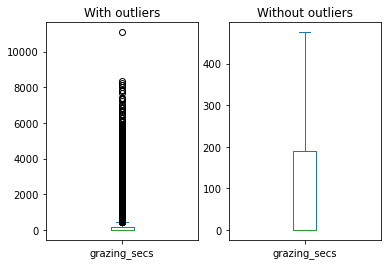

In [12]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > max_graze_secs])))

In [13]:
# drop grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] < max_graze_secs].copy(deep=True)

# convert grazing secs to integer
df_wkly_grid_full['grazing_secs'] = df_wkly_grid_full['grazing_secs'].astype('int')

In [14]:
"""
Flag and remove any outliers beyond last bin with only one pixel
"""

secs_bin_size = 60 * 5

def flag_graze_outliers(x, bins=np.arange(-5, max_graze_secs, secs_bin_size)):
    try:
        groups = x.groupby(pd.cut(x, bins, include_lowest=False))
        one_bins = bins[:-1][(groups.count() == 1).values] 
        gt_one_bins = bins[:-1][(groups.count() > 1).values] 
        last_one_bin = np.min([np.max(gt_one_bins) + secs_bin_size, np.max([np.min(one_bins), np.max(gt_one_bins)])])
        return (x >= last_one_bin).astype('int')
    except ValueError:
        return 0

df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    90.000000
mean      2.133333
std       1.697321
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       8.000000
Name: grazing_secs_outlier, dtype: float64

In [15]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [16]:
df_wkly_grid_full['season_str'] = df_wkly_grid_full['season'].astype(str)#.value_counts()

In [17]:
"""
Calculate total weekly grazing seconds per pasture-season to use as offset to account for missing data
"""
df_wkly_grid_full.loc[:, 'grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture',
                                                                          'week',
                                                                          'Year',
                                                                          'season_str'])['grazing_secs'].transform('sum').values

In [18]:
df_wkly_grid_full.groupby(['Pasture',
                           'week',
                           'Year',
                           'season_str'])['grazing_wkly_sum'].value_counts()

Pasture  week  Year  season_str  grazing_wkly_sum
15E      19    2017  early       104477              2685
         20    2017  early       354769              2683
               2018  early       165761              1343
         21    2016  early       122146              1342
               2017  early       372794              2686
                                                     ... 
7NW      38    2017  late        196386              1332
               2018  late        215342              1331
         39    2016  late        247657              2664
               2017  late        266910              2664
               2018  late        162144              1332
Name: grazing_wkly_sum, Length: 474, dtype: int64

In [19]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid_full.loc[:, 'grazing_rel_freq'] = df_wkly_grid_full['grazing_secs'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                             df_wkly_grid_full.groupby(
                                                                                 ['Pasture', 
                                                                                  'week',
                                                                                  'Year',
                                                                                  'season_str'])['grazing_secs'].transform('count'))
df_wkly_grid_full['grazing_rel_freq'].describe()

count    949815.000000
mean          1.000000
std           1.868581
min           0.000000
25%           0.000000
50%           0.000000
75%           1.314237
max          58.019432
Name: grazing_rel_freq, dtype: float64

In [20]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_vars=False
if scale_vars:
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        for past in df_wkly_grid_full['Pasture'].unique():
            for wk in df_wkly_grid_full[df_wkly_grid_full['Pasture'] == past]['week'].unique():
                scaler.fit(df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c].values.reshape(-1, 1))
                df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c] = scaler.transform(
                    df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c].values.reshape(-1, 1)).flatten()
#for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
#    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [21]:
df = df_wkly_grid_full.groupby(['Year', 'Pasture', 'week', 'UTM_X', 'UTM_Y']).mean().reset_index()

In [22]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [23]:
df_corr = pd.DataFrame(columns=['Pasture', 'week', 'lag', 'grz_grz_cor', 'bm_grz_cor', 'cp_grz_cor'])
#past = '31E'
for past in tqdm(df['Pasture'].unique()):
    df_sub_tmp = df[df['Pasture'] == past]
    idx = 0
    for yr in df_sub_tmp['Year'].unique():
        df_sub = df_sub_tmp[df_sub_tmp['Year'] == yr].copy()
        df_sub['grazing_rel_freq'] = df_sub['grazing_rel_freq'].apply(lambda x: np.log(1 + x))
        df_sub = df_sub.set_index(
            ['UTM_X', 'UTM_Y'])[(df_sub.groupby(
            ['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())).reindex(
            df_sub.set_index(['UTM_X', 'UTM_Y']).index)].reset_index()
        for c in ['Biomass', 'CP', 'PC_div']:
            df_sub[c] = scaler.fit_transform(df_sub[c].values.reshape(-1, 1)).flatten()
        for wk in df_sub['week'].unique():
            for wk2 in df_sub[df_sub['week'] < wk]['week'].unique():
                lag_i = wk2-wk
                grz_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['grazing_rel_freq'])
                bm_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['Biomass'])
                cp_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['CP'])
                grz_bm_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk2]['grazing_rel_freq'], df_sub[df_sub['week'] == wk]['Biomass'])
                grz_cp_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk2]['grazing_rel_freq'], df_sub[df_sub['week'] == wk]['CP'])

                if lag_i != 0:
                    x_bm_list = []
                    x_cp_list = []
                    x_grz_list = []
                    for wk_i in range(min(wk2, wk), max(wk2, wk)):
                        grz_vals_tmp = df_sub[df_sub['week'] == wk_i]['grazing_rel_freq'].values
                        bm_vals_tmp = df_sub[df_sub['week'] == wk_i]['Biomass'].values
                        cp_vals_tmp = df_sub[df_sub['week'] == wk_i]['CP'].values
                        if len(grz_vals_tmp) > 0:
                            x_grz_list.append(np.array(grz_vals_tmp))
                        if len(bm_vals_tmp) > 0:
                            x_bm_list.append(np.array(bm_vals_tmp))
                        if len(cp_vals_tmp) > 0:
                            x_cp_list.append(np.array(cp_vals_tmp))

                    x_grz = np.array(x_grz_list).transpose()
                    x_grz = add_constant(x_grz)
                    f_grz_bm = sm.RLM(df_sub[df_sub['week'] == wk]['Biomass'], x_grz, hasconst=True).fit()
                    f_grz_cp = sm.RLM(df_sub[df_sub['week'] == wk]['CP'], x_grz, hasconst=True).fit()

                    x_bm = np.array(x_bm_list).transpose()
                    x_bm = add_constant(x_bm)
                    f_bm = sm.RLM(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], x_bm, hasconst=True).fit()

                    x_cp = np.array(x_cp_list).transpose()
                    x_cp = add_constant(x_cp)
                    f_cp = sm.RLM(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], x_cp, hasconst=True).fit()

                    grz_bm_lr_coef_tmp = sum(f_grz_bm.params[1:])
                    grz_cp_lr_coef_tmp = sum(f_grz_cp.params[1:])
                    bm_lr_coef_tmp = sum(f_bm.params[1:])
                    cp_lr_coef_tmp = sum(f_cp.params[1:])

                    if lag_i < 0:
                        grz_bm_sr_coef_tmp = f_grz_bm.params[1]
                        grz_cp_sr_coef_tmp = f_grz_cp.params[1]
                        bm_sr_coef_tmp = f_bm.params[1]
                        cp_sr_coef_tmp = f_cp.params[1]
                    if lag_i > 0:
                        grz_bm_sr_coef_tmp = f_grz_bm.params[-1]
                        grz_cp_sr_coef_tmp = f_grz_cp.params[-1]
                        bm_sr_coef_tmp = f_bm.params[-1]
                        cp_sr_coef_tmp = f_cp.params[-1]
                else:
                    bm_coef_tmp = np.nan
                df_tmp = pd.DataFrame(data={'Year': yr,
                                            'Pasture': past,
                                            'week': wk,
                                            'lag': lag_i,
                                            'grz_grz_cor': grz_grz_corr_tmp[0, 1],
                                            'bm_grz_cor': bm_grz_corr_tmp[0, 1],
                                            'cp_grz_cor': cp_grz_corr_tmp[0, 1],
                                            'grz_bm_cor': grz_bm_corr_tmp[0, 1],
                                            'grz_cp_cor': grz_cp_corr_tmp[0, 1],
                                            'grz_bm_lr_coef': grz_bm_lr_coef_tmp,
                                            'grz_cp_lr_coef': grz_cp_lr_coef_tmp,
                                            'bm_lr_coef': bm_lr_coef_tmp,
                                            'cp_lr_coef': cp_lr_coef_tmp,
                                            'grz_bm_sr_coef': grz_bm_sr_coef_tmp,
                                            'grz_cp_sr_coef': grz_cp_sr_coef_tmp,
                                            'bm_sr_coef': bm_sr_coef_tmp,
                                            'cp_sr_coef': cp_sr_coef_tmp},
                                      index=[idx])
                df_corr = pd.concat([df_corr, df_tmp])
                idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
df_corr['season'] = df_corr['week'].apply(lambda x: season_func(x))
df_corr.loc[df_corr['lag'] == 0, 'grz_grz_cor'] = np.nan

In [28]:
df_corr = df_corr.set_index(['season',
                   'Year',
                   'lag'])[(df_corr.groupby(['season', 'Year'])['lag'].value_counts() > 3).reindex(df_corr.set_index(['season',
                   'Year',
                   'lag']).index)]

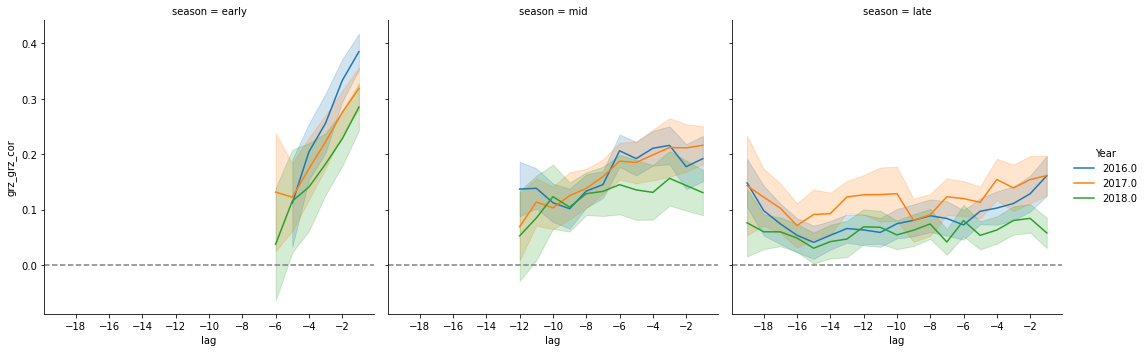

In [29]:
from matplotlib.ticker import MaxNLocator

g = sns.relplot(x='lag', y='grz_grz_cor', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))

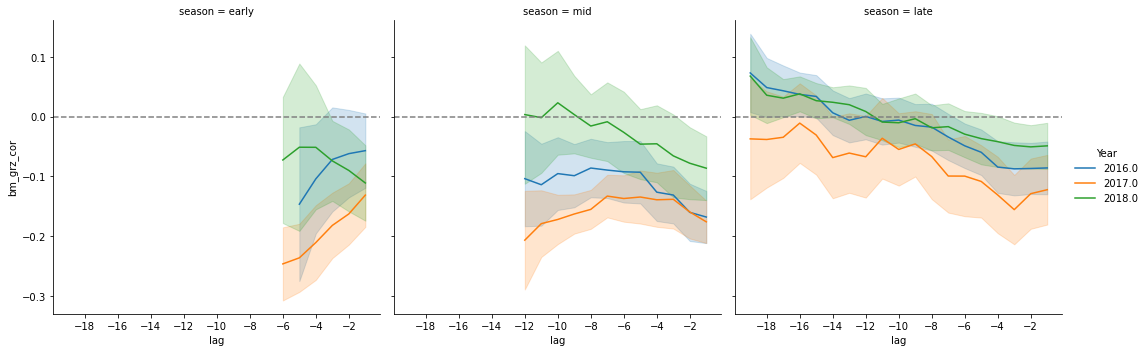

In [30]:
g = sns.relplot(x='lag', y='bm_grz_cor', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))

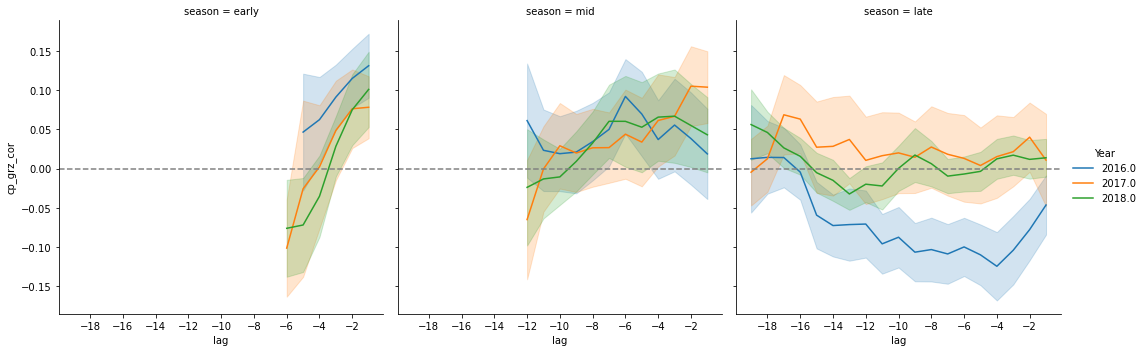

In [36]:
g = sns.relplot(x='lag', y='cp_grz_cor', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))

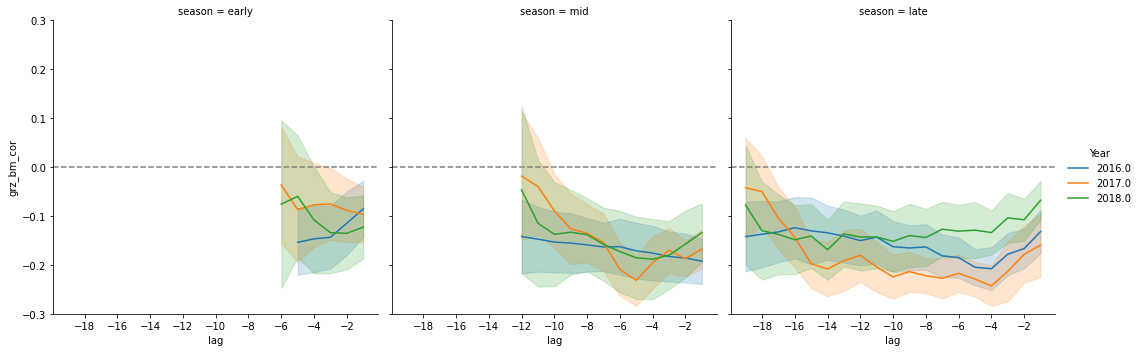

In [31]:
g = sns.relplot(x='lag', y='grz_bm_cor', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))
    ax.set_ylim(-0.3, 0.3)

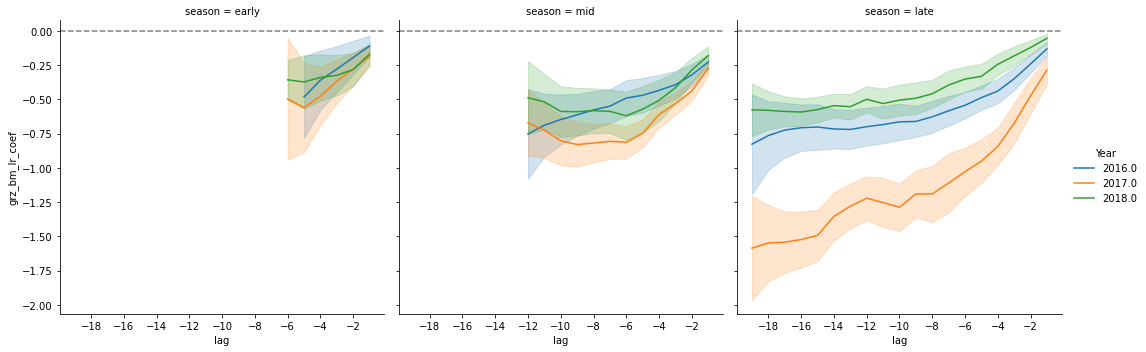

In [35]:
g = sns.relplot(x='lag', y='grz_bm_lr_coef', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))
    #ax.set_ylim(-0.8, 0.2)

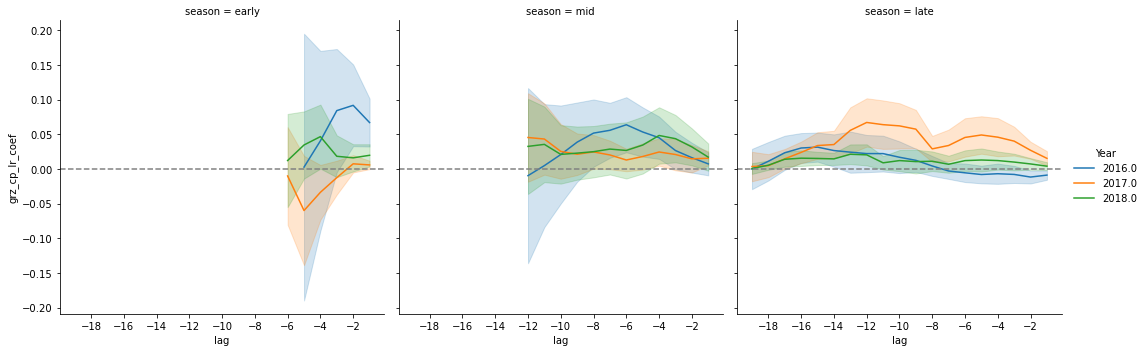

In [33]:
g = sns.relplot(x='lag', y='grz_cp_lr_coef', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))
    #ax.set_ylim(-0.2, 0.2)

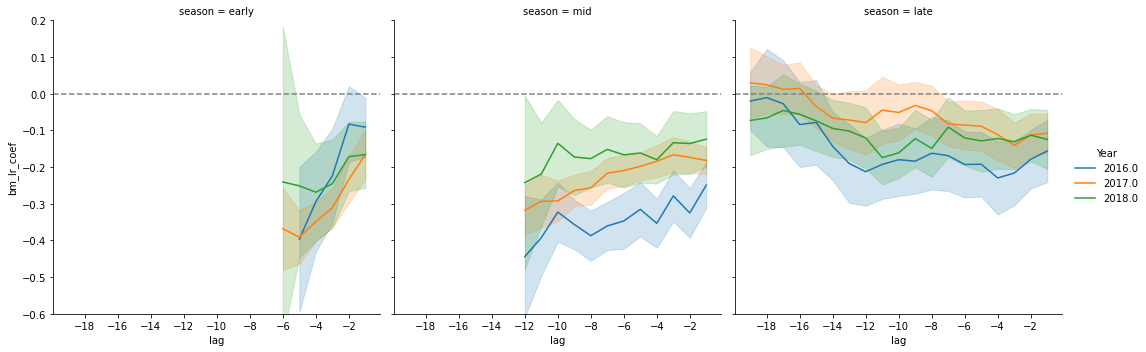

In [71]:
g = sns.relplot(x='lag', y='bm_lr_coef', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))
    ax.set_ylim(-0.6, 0.2)

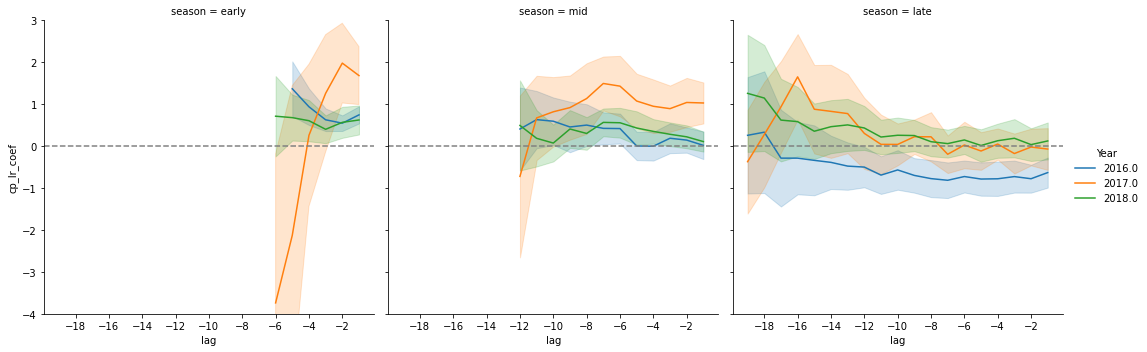

In [74]:
g = sns.relplot(x='lag', y='cp_lr_coef', kind='line', hue='Year', col='season', data=df_corr, errorbar=('se', 2), palette='tab10')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.xaxis.set_major_locator(MaxNLocator(steps=[1, 2], integer=True))
    ax.set_ylim(-4.0, 3.0)

In [86]:
lag_max = 5
df_lreg = pd.DataFrame(columns=['Pasture', 'week', 'lag'])
#past = '31E'
for past in tqdm(df['Pasture'].unique()):
    df_sub_tmp = df[df['Pasture'] == past]
    idx = 0
    for yr in df_sub_tmp['Year'].unique():
        df_sub = df_sub_tmp[df_sub_tmp['Year'] == yr]
        df_sub = df_sub.set_index(
            ['UTM_X', 'UTM_Y'])[(df_sub.groupby(
            ['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())).reindex(
            df_sub.set_index(['UTM_X', 'UTM_Y']).index)].reset_index()
        for c in ['Biomass', 'CP', 'PC_div']:
            df_sub[c] = scaler.fit_transform(df_sub[c].values.reshape(-1, 1)).flatten()
        for wk in df_sub['week'].unique():
            for lag_i in range(1, lag_max):
                wk2 = wk - lag_i
                x_grz_list = []
                for wk_i in range(min(wk2, wk), max(wk2, wk)):
                    grz_vals_tmp = df_sub[df_sub['week'] == wk_i]['grazing_rel_freq'].values
                    if len(grz_vals_tmp) > 0:
                        x_grz_list.append(np.array(grz_vals_tmp))
                x_grz_list.append(np.array(df_sub[df_sub['week'] == wk]['Biomass'].values))
                x_grz_list.append(np.array(df_sub[df_sub['week'] == wk]['CP'].values))
                x_grz = np.array(x_grz_list).transpose()
                x_grz = add_constant(x_grz)
                f_all = sm.RLM(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], x_grz, hasconst=True).fit()

                bm_coef_tmp = f_all.params[-2]
                cp_coef_tmp = f_all.params[-1]

                df_tmp = pd.DataFrame(data={'Year': yr,
                                            'Pasture': past,
                                            'week': wk,
                                            'lag': lag_i,
                                            'bm_coef': bm_coef_tmp,
                                            'cp_coef': cp_coef_tmp},
                                      index=[idx])
                df_lreg = pd.concat([df_lreg, df_tmp])
                idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
df_lreg['season'] = df_lreg['week'].apply(lambda x: season_func(x))

In [91]:
df_lreg_long = pd.melt(df_lreg, id_vars=['Pasture', 'week', 'lag', 'Year', 'season'], value_vars=['bm_coef', 'cp_coef'], 
        var_name='variable', value_name='coef')

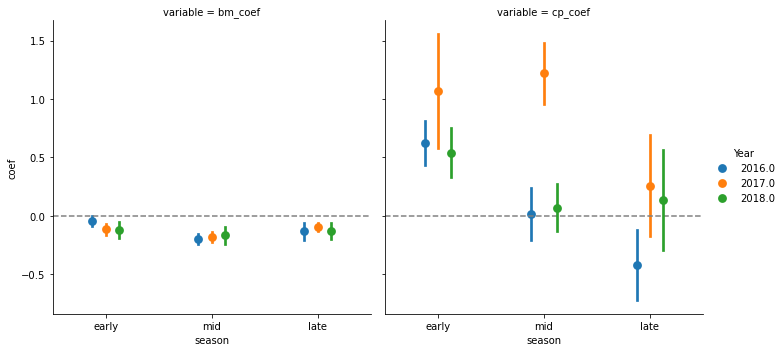

In [97]:
g = sns.catplot(x='season', y='coef', hue='Year', col='variable',
                data=df_lreg_long[df_lreg_long['lag'] == lag_max-1], kind='point', errorbar=('se', 2), join=False, dodge=0.25)
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')